In [1]:
import sys

sys.path.insert(0, '../')
from shared import *

The first step is to combine all of the pre-computed face landmarks across the 25 batches (~ 5 days of on-and-off computational work). Then, the `numpy` arrays can be easily combined into the original data frame to make have all of the relevant data in a single place.

In [2]:
from glob import glob
from funcy import rpartial
from toolz import pipe
from toolz.curried import *
import numpy as np
import re

def regex_numeric(value):
    return int(re.search('\d+', value).group(0))

def from_npz(values, npz_file):
    next_values = npz_file['arr_0']
    npz_file.close()
    return np.append(values, next_values)

landmarks = pipe(
    './*.npz',
    glob,
    sorted(key = regex_numeric),
    list,
    map(np.load),
    lambda npzs: reduce(from_npz, npzs, np.empty(0)))

print('landmarks', landmarks.shape)

df = capture_df()
df['Landmarks'] = landmarks

landmarks (2445504,)


From here, random samples can be taken to verify that the landmarks properly correspond to each image at the same index. Note that images that do not have any landmarks detected are denoted by an empty `numpy` array.

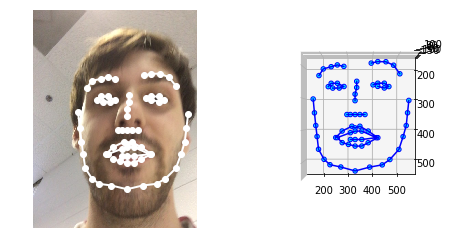

In [77]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_row(row):
    preds = row.at['Landmarks']
    fig = plt.figure(figsize=plt.figaspect(.5))
    ax = fig.add_subplot(1, 2, 1)
    ax.imshow(frame(row))
    ax.plot(preds[0:17,0],preds[0:17,1],marker='o',markersize=6,linestyle='-',color='w',lw=2)
    ax.plot(preds[17:22,0],preds[17:22,1],marker='o',markersize=6,linestyle='-',color='w',lw=2)
    ax.plot(preds[22:27,0],preds[22:27,1],marker='o',markersize=6,linestyle='-',color='w',lw=2)
    ax.plot(preds[27:31,0],preds[27:31,1],marker='o',markersize=6,linestyle='-',color='w',lw=2)
    ax.plot(preds[31:36,0],preds[31:36,1],marker='o',markersize=6,linestyle='-',color='w',lw=2)
    ax.plot(preds[36:42,0],preds[36:42,1],marker='o',markersize=6,linestyle='-',color='w',lw=2)
    ax.plot(preds[42:48,0],preds[42:48,1],marker='o',markersize=6,linestyle='-',color='w',lw=2)
    ax.plot(preds[48:60,0],preds[48:60,1],marker='o',markersize=6,linestyle='-',color='w',lw=2)
    ax.plot(preds[60:68,0],preds[60:68,1],marker='o',markersize=6,linestyle='-',color='w',lw=2) 
    ax.axis('off')

    ax = fig.add_subplot(1, 2, 2, projection='3d')
    surf = ax.scatter(preds[:,0]*1.2,preds[:,1],preds[:,2],c="cyan", alpha=1.0, edgecolor='b')
    ax.plot3D(preds[:17,0]*1.2,preds[:17,1], preds[:17,2], color='blue' )
    ax.plot3D(preds[17:22,0]*1.2,preds[17:22,1],preds[17:22,2], color='blue')
    ax.plot3D(preds[22:27,0]*1.2,preds[22:27,1],preds[22:27,2], color='blue')
    ax.plot3D(preds[27:31,0]*1.2,preds[27:31,1],preds[27:31,2], color='blue')
    ax.plot3D(preds[31:36,0]*1.2,preds[31:36,1],preds[31:36,2], color='blue')
    ax.plot3D(preds[36:42,0]*1.2,preds[36:42,1],preds[36:42,2], color='blue')
    ax.plot3D(preds[42:48,0]*1.2,preds[42:48,1],preds[42:48,2], color='blue')
    ax.plot3D(preds[48:,0]*1.2,preds[48:,1],preds[48:,2], color='blue' )

    ax.view_init(elev=90., azim=90.)
    ax.set_xlim(ax.get_xlim()[::-1])
    plt.show()

plot_row(df.iloc[2423100])

In [124]:
from funcy import flatten

@curry
def axis_landmarks(n, lms):
    return lms[:, n] if lms.shape[0] != 0 else np.empty(0)

def points_on_axis(n):
    return pipe(landmarks, map(axis_landmarks(n)), flatten, list)

landmarks_non_empty = np.array(list(filter(lambda x: x.shape[0] > 0, landmarks)))

x = np.vstack(landmarks_non_empty)[:, 0]
y = np.vstack(landmarks_non_empty)[:, 1]
z = np.vstack(landmarks_non_empty)[:, 2]

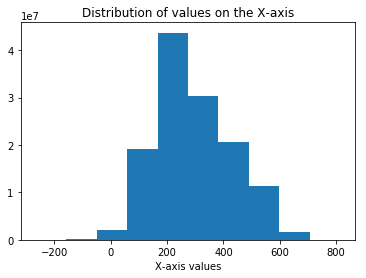

min -266.0
max 814.0
mean 294.03125
median 272.0


In [133]:
plt.hist(x)
plt.title('Distribution of values on the X-axis')
plt.xlabel('X-axis values')
plt.show()

print('min', np.min(x))
print('max', np.max(x))
print('mean', np.mean(x))
print('median', np.median(x))

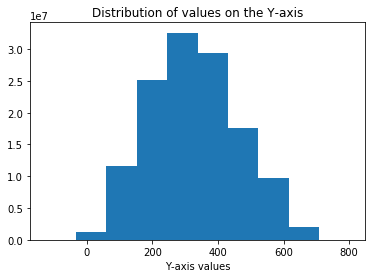

min -126.0
max 802.0
mean 326.52066
median 321.0


In [134]:
plt.hist(y)
plt.title('Distribution of values on the Y-axis')
plt.xlabel('Y-axis values')
plt.show()

print('min', np.min(y))
print('max', np.max(y))
print('mean', np.mean(y))
print('median', np.median(y))

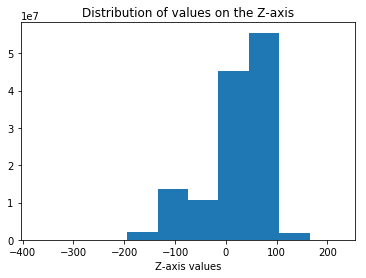

min -374.14056
max 225.13248
mean 21.106413
median 39.93457


In [135]:
plt.hist(z)
plt.title('Distribution of values on the Z-axis')
plt.xlabel('Z-axis values')
plt.show()

print('min', np.min(z))
print('max', np.max(z))
print('mean', np.mean(z))
print('median', np.median(z))

min -266.0
max 814.0


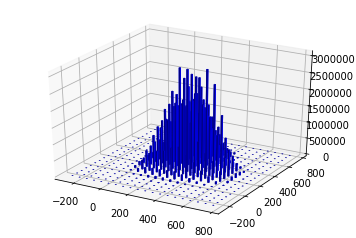

In [160]:
def hist3d_data(x_values, y_values):
    min_value = min(np.min(x_values), np.min(y_values))
    max_value = max(np.max(x_values), np.max(y_values))
    print('min', min_value)
    print('max', max_value)
        
    # Mostly from 
    hist, xedges, yedges = np.histogram2d(x, y, bins=20,
                                          range=[[min_value, max_value], [min_value, max_value]])

    # Construct arrays for the anchor positions of the bars.
    # Note: np.meshgrid gives arrays in (ny, nx) so we use 'F' to flatten xpos,
    # ypos in column-major order. For numpy >= 1.7, we could instead call meshgrid
    # with indexing='ij'.
    xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25, indexing='ij')
    xpos = xpos.flatten('F')
    ypos = ypos.flatten('F')
    zpos = np.zeros_like(xpos)

    # Construct arrays with the dimensions for the 16 bars.
    dx = 10 * np.ones_like(zpos)
    dy = dx.copy()
    dz = hist.flatten()
    
    return ((xpos, ypos, zpos), (dx, dy, dz))


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
(xpos, ypos, zpos), (dx, dy, dz) = hist3d_data(x, y)
ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color='b', zsort='average')
plt.show()